### Setup

In [1]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import cv2
from IPython import display

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Load and prepare the dataset

In [3]:
directory = '/mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/Health/Leukomia/splitted_aug/leukocyte/classify train/training/0'

In [4]:
img_list = []
for filename in os.listdir(directory):
    file = os.path.join(directory, filename)
    img = cv2.imread(file,0)
    img_list.append(img)
    w = img.shape[0]
    h = img.shape[1]

In [5]:
img.shape

(64, 64)

In [6]:
train_images = np.array(img_list)

In [7]:
train_images.shape[0]

131

In [8]:
train_images = train_images.reshape(train_images.shape[0], w, h, 1).astype('float32')

In [9]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [10]:
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 8
noise_dim = 100

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()


    model.add(layers.Dense(4*4*512, use_bias = False, input_shape = (noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape(( 4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512) # Note: None is the batch size


    model.add(layers.Conv2DTranspose(256, (3,3), strides = (2,2), padding = "same", use_bias = False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(128, (3,3), strides = (2,2), padding = "same", use_bias = False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(64, (3,3), strides = (2,2), padding = "same", use_bias = False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2DTranspose(1, (3,3), strides = (2,2), padding = "same", use_bias = False, activation = "tanh"))
    assert model.output_shape == (None, w, h, 1)

  
    return model

Use the (as yet untrained) generator to create an image.

In [13]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         1179648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0

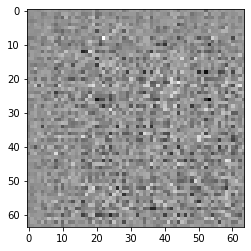

In [14]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[w, h, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
      
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(256))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1))
     
    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [16]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)        

In [17]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00012437]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [23]:
EPOCHS = 1
num_examples_to_generate = 500

seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [24]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 1000 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [26]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure()
    for i in range(predictions.shape[0]):
        tensor = predictions[i, :, :, 0] * 127.5 + 127.5
        plt.axis('off')
        plt.tight_layout()
        plt.margins(0,0)
        plt.imshow(tensor, cmap='gray')
        plt.savefig('/mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/Health/Leukomia/splitted_aug/leukocyte/gan_gray_jpg/0/{:04d}.jpg'.format(i), bbox_inches='tight', pad_inches = 0, transparent=True)

    plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

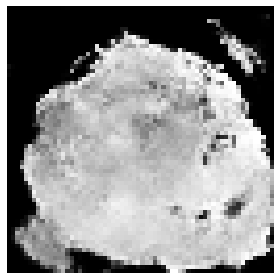

Time for epoch 1 is 1778.9981944561005 sec


In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))